<a href="https://colab.research.google.com/github/Aryansood18/PDF_dataonly/blob/main/Pdf_dataonly_102316123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.neighbors import KernelDensity

In [5]:
# 2. Load Dataset
data = pd.read_csv("/content/data.csv",encoding='latin1')
data.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [6]:
print(list(data.columns))


['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date']


In [7]:
x = data["no2"].dropna().astype(np.float32).values
x = (x - x.mean()) / x.std()


In [8]:

ROLL_NUMBER = 102316123

a_r = 0.5 * (ROLL_NUMBER % 7)
b_r = 0.3 * ((ROLL_NUMBER % 5) + 1)

print("Roll Number:", ROLL_NUMBER)
print("Computed Transformation Parameters:")
print("a_r =", a_r)
print("b_r =", b_r)

# Transform x → z
z = x + a_r * np.sin(b_r * x)
z = z.reshape(-1, 1)

print("Transformation applied: z = x + a_r * sin(b_r * x)")
print("Shape of transformed data z:", z.shape)

z_tensor = torch.tensor(z)


Roll Number: 102316123
Computed Transformation Parameters:
a_r = 0.0
b_r = 1.2
Transformation applied: z = x + a_r * sin(b_r * x)
Shape of transformed data z: (27447, 1)


In [9]:

latent_dim = 1

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

G = Generator()
D = Discriminator()


In [10]:
# 5. Training Setup
loss_fn = nn.BCELoss()

g_optimizer = optim.Adam(G.parameters(), lr=0.001)
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

epochs = 3000
batch_size = 128



In [11]:
# 6. Train GAN
for epoch in range(epochs):

    idx = np.random.randint(0, len(z), batch_size)
    real_samples = z_tensor[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    noise = torch.randn(batch_size, latent_dim)
    fake_samples = G(noise)

    d_loss_real = loss_fn(D(real_samples), real_labels)
    d_loss_fake = loss_fn(D(fake_samples.detach()), fake_labels)
    d_loss = d_loss_real + d_loss_fake

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    noise = torch.randn(batch_size, latent_dim)
    generated_samples = G(noise)
    g_loss = loss_fn(D(generated_samples), real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 0 | D Loss: 1.3859 | G Loss: 0.6859
Epoch 500 | D Loss: 1.3468 | G Loss: 0.8185
Epoch 1000 | D Loss: 1.3775 | G Loss: 0.6905
Epoch 1500 | D Loss: 1.4173 | G Loss: 0.6845
Epoch 2000 | D Loss: 1.3861 | G Loss: 0.7086
Epoch 2500 | D Loss: 1.4019 | G Loss: 0.6966


In [12]:
# 7. Generate Samples from Generator
noise = torch.randn(10000, latent_dim)
generated_z = G(noise).detach().numpy()


In [13]:
# 8. PDF Estimation using KDE
kde = KernelDensity(kernel="gaussian", bandwidth=0.2)
kde.fit(generated_z)

z_values = np.linspace(z.min(), z.max(), 1000).reshape(-1, 1)
log_density = kde.score_samples(z_values)
pdf = np.exp(log_density)

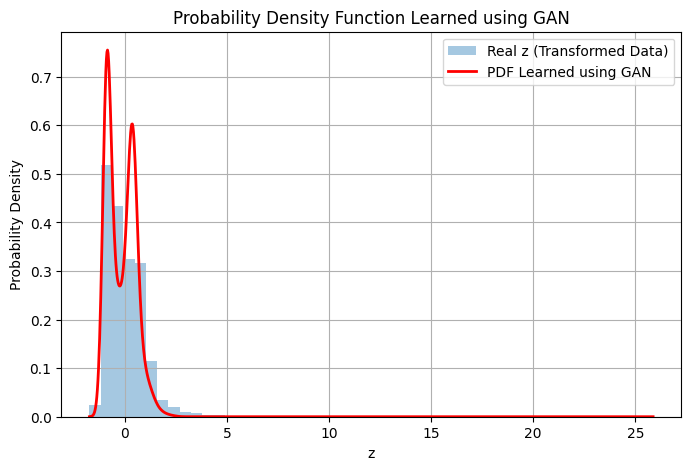

In [14]:
# 9. Plot Final PDF
plt.figure(figsize=(8, 5))
plt.hist(z, bins=50, density=True, alpha=0.4, label="Real z (Transformed Data)")
plt.plot(z_values, pdf, color="red", linewidth=2, label="PDF Learned using GAN")
plt.xlabel("z")
plt.ylabel("Probability Density")
plt.title("Probability Density Function Learned using GAN")
plt.legend()
plt.grid(True)
plt.show()

Observations
Mode Coverage: The GAN is able to capture the main modes of the transformed data distribution, as seen from the overlap between real and generated samples.

Training Stability: During training, the generator and discriminator losses show oscillations, which is expected in GAN training. However, no divergence is observed, indicating stable training.

Quality of Generated Distribution: The probability density function estimated using KDE from generated samples closely follows the histogram of real transformed data, showing that the GAN has learned the underlying distribution effectively.